In [1]:
%matplotlib inline

# Visualización de modelos, datos y entrenamiento con TensorBoard

Hasta ahora se ha enseñado cómo cargar datos, alimentarlos a través de un modelo que definimos como una subclase ``nn.Module``, entrenar este modelo con datos de entrenamiento y probarlo con datos de prueba. Para ver qué está sucediendo, imprimimos algunas estadísticas a medida que el modelo se está entrenando para tener una idea de si el entrenamiento está progresando. Sin embargo, podemos hacerlo mucho mejor que eso: PyTorch se integra con TensorBoard, una herramienta diseñada para visualizar los resultados de las ejecuciones de entrenamiento de redes neuronales. Este tutorial ilustra algunas de sus funciones, usando el [conjunto de datos Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) que se puede leer en PyTorch usando ``torchvision.datasets``.

En este tutorial, aprenderemos cómo:

 1. Leer datos y con las transformaciones adecuadas (casi idénticas al tutorial anterior).
 2. Configura TensorBoard.
 3. Escribe en TensorBoard.
 4. Inspeccionar una arquitectura de modelo con TensorBoard.
 5. Usar TensorBoard para crear versiones interactivas de las visualizaciones que creamos en el último tutorial, con menos código

Específicamente, en el punto # 5, veremos:

 * Un par de formas de inspeccionar nuestros datos de entrenamiento
 * Cómo realizar un seguimiento del rendimiento de nuestro modelo mientras se entrena
 * Cómo evaluar el desempeño de nuestro modelo una vez entrenado.

Comenzaremos con un código similar al del tutorial sobre [CIFAR-10](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html):

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
batch_size = 4
num_workers = 2
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=num_workers)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=num_workers)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

26422272it [00:26, 989781.52it/s]                               


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



29696it [00:00, 443919.52it/s]           


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



4422656it [00:04, 1020009.59it/s]                             


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



6144it [00:00, 1536111.34it/s]          

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw




C:\Users\mfnunez\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Definiremos una arquitectura de modelo similar a partir de ese tutorial, haciendo solo modificaciones menores para tener en cuenta el hecho de que las imágenes ahora son un canal en lugar de tres y 28x28 en lugar de 32x32:

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

Definiremos el mismo ``optimizer`` y ``criterion`` de antes:

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


## 1. Configuración de TensorBoard

Ahora vamos a configurar TensorBoard, la importación de ``tensorboard`` desde ``torch.utils`` y definiendo una ``SummaryWriter``, nuestro objeto clave para escribir información en TensorBoard.

In [7]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

Tenga en cuenta que esta línea sola crea una carpeta ``runs/fashion_mnist_experiment_1``.

## 2. Escribiendo en TensorBoard

Ahora escribamos una imagen en nuestro TensorBoard, específicamente, una cuadrícula, usando [make_grid](https://pytorch.org/vision/stable/utils.html#torchvision.utils.make_grid).

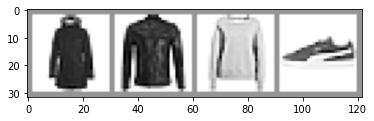

In [8]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

Ahora se ejecuta tensorboard

In [10]:
%tensorboard --logdir=runs

UsageError: Line magic function `%tensorboard` not found.
